<a href="https://colab.research.google.com/github/radekosmulski/latent_macaque/blob/master/macaque_calls_librosa_umap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will explore macaque vocalizations.

8 adult rhesus macaques were recorder resulting in 7285 recordings. You can read more about how the data was collected in [Distributed acoustic cues for caller identity in macaque vocalization](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4806230/) by Makoto Fukushima, Alex M. Doyle, Matthew P. Mullarkey, Mortimer Mishkin, and Bruno B. Averbeck.

The meticulously collected data was put in the public domain allowing us to study this fascinating subject! Heartfelt thank you to the authors!

The main purpose of this notebook is to explore the visualization of latent space and also start gaining insights into how projections into latent space can lend themselves to interesting research. The methods I am planning to explore in this notebook come from this absolutely fabulous paper, [Latent space visualization, characterization, and generation of diverse vocal communication signals by](https://www.biorxiv.org/content/10.1101/870311v2) Tim Sainburg,  Marvin Thielk and Timothy Q Gentner. The authors share the code for the techniques described in the paper on github [here](https://github.com/timsainb/avgn_paper). Specifically, I am focusing on the work in this [NB](https://github.com/timsainb/avgn_paper/blob/vizmerge/notebooks/00.1-data-exploration/macaque/0.0-Macaque-Data%20Exploration.ipynb).

Let's look at step by step what they did and see what we can learn from observing their work!

Let's download the data (I preprocessed it to live in a pandas DataFrame for convenience).

In [1]:
!gsutil cp gs://ml-animal-sounds-datasets/Fukushima2015.pickle .

Copying gs://ml-animal-sounds-datasets/Fukushima2015.pickle...
/ [1 files][215.2 MiB/215.2 MiB]                                                
Operation completed over 1 objects/215.2 MiB.                                    


In [0]:
%matplotlib inline

import pathlib
import pandas as pd
import numpy as np
import librosa, librosa.display
import warnings
import matplotlib.pyplot as plt

In [0]:
wav_df = pd.read_pickle('Fukushima2015.pickle')
sr = 22050

We can listen to one of the recordings.

In [4]:
from IPython.display import Audio
Audio(data=wav_df.iloc[0].vocdata, rate=sr)

In [5]:
wav_df.shape

(7285, 6)

In [6]:
wav_df.head()

,loc,indv,idnum,vocdata,rate,voc_len
0,data/QU/QU769.wav,QU,769,"[0.0049249623, 0.0054234797, 0.0048547825, 0.0...",22050,0.545442
1,data/QU/QU966.wav,QU,966,"[-0.0045941705, -0.004401, -0.00305672, -0.002...",22050,0.632653
2,data/QU/QU642.wav,QU,642,"[-0.0070351074, -0.007406098, -0.006161498, -0...",22050,0.653696
3,data/QU/QU597.wav,QU,597,"[-0.003954887, -0.004979008, -0.005174741, -0....",22050,0.457868
4,data/QU/QU836.wav,QU,836,"[0.0058898614, 0.005771, 0.0042763287, 0.00353...",22050,0.444580


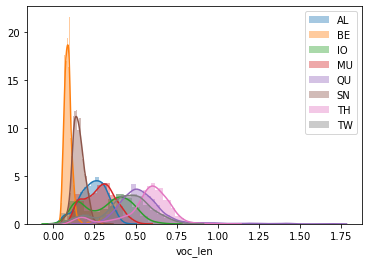

In [7]:
import seaborn as sns

# length of vocalizations per individual
for indv in np.unique(wav_df.indv):
    sns.distplot( wav_df[wav_df.indv==indv]["voc_len"], label=indv)
plt.legend()

In [8]:
(wav_df.voc_len > 0.7).mean()

0.03788606726149622

There are only a few recordings that are over 0.7 second long (fewer than 4%!). For the purposes of this activity, we can treat them as outliers and remove them

In [0]:
wav_df = wav_df[wav_df.voc_len < 0.7]

Center padding the signal to equal length across all examples.

In [0]:
wav_df.vocdata = wav_df.vocdata.map(lambda x: librosa.util.pad_center(x, sr * 0.7))

The next step is to generate a spectrogram for each of the recordings.

In [0]:
def vocdata2hist(vocdata):
    hop_length = 128
    n_fft = 1024
    S = librosa.stft(vocdata, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(abs(S))

    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', fmin=50, fmax=5000)
    ax = plt.gca()
    ax.figure.set_dpi(1)
    ax.figure.set_figheight(30)
    ax.figure.set_figwidth(60)
    ax.axis('off')

    ax.figure.canvas.draw()
    plt.close()

    data = np.frombuffer(ax.figure.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(ax.figure.canvas.get_width_height()[::-1] + (3,))

    return data

In [0]:
plt.ioff()

In [13]:
%%time

wav_df['spec'] = wav_df.vocdata.map(lambda x: vocdata2hist(x))

CPU times: user 6min 35s, sys: 1.58 s, total: 6min 37s
Wall time: 6min 37s


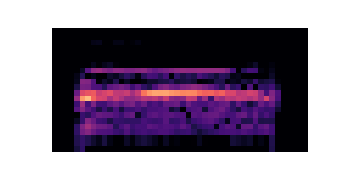

In [14]:
plt.imshow(wav_df.spec[1106])
plt.axis('off');

In [0]:
import umap
import seaborn as sns

In [16]:
specs = np.stack(wav_df.spec.values)
specs_flattened = np.reshape(specs, (np.shape(specs)[0], np.prod(np.shape(specs)[1:])))
len(specs_flattened)

7008

In [17]:
fit = umap.UMAP()
%time u_all = fit.fit_transform(specs_flattened)

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/utils.py", line 409:
@numba.njit(parallel=True

CPU times: user 35.8 s, sys: 1.14 s, total: 36.9 s
Wall time: 35.8 s


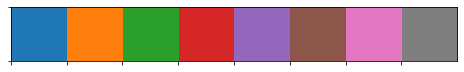

In [18]:
labs = wav_df.indv.values
pal = sns.color_palette(n_colors=len(np.unique(labs)))
sns.palplot(pal)
lab_dict = {lab:pal[i] for i, lab in enumerate(np.unique(labs))}
colors = np.array([lab_dict[i] for i in labs])

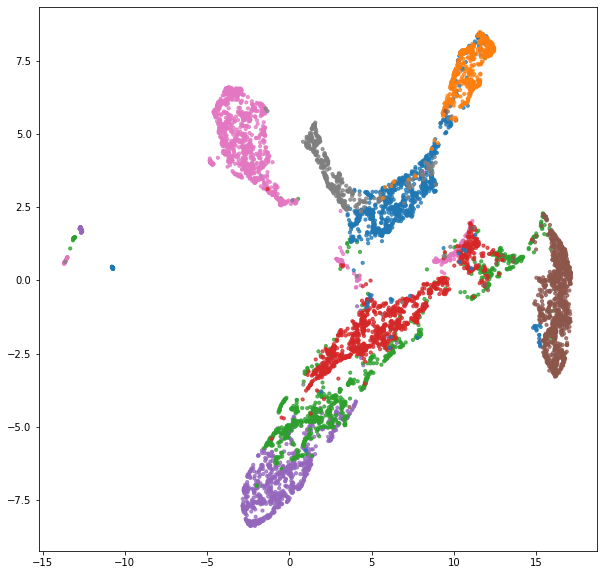

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(u_all[:,0], u_all[:,1], alpha = 0.75, s=10, color=colors)